DMI data generated
TRMM data generated
ELNino data generated


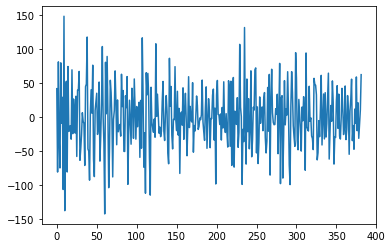

In [2]:
import netCDF4
import matplotlib.pyplot as plt
import datetime 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statistics as stats
import os

import numpy as np
import copy
import scipy.stats as sp
import pandas as pd
import random


filename= 'TRMM1/3B42_Daily.19980101.7.nc4.nc4'
f=netCDF4.Dataset(filename)
lat, lon= [f.variables['lat'][:], f.variables['lon'][:]] #13 longitudes, 11 latitudes



class ReadData:
    """
    ReadData-- generates the dataset
    
    TODO: currently doesn't use generators, so it can be slow.
    """
    DMI_data = {}
    DMI_list = [] #sorted version of the dictionary
    sortedKeys_DMI = []
    TRMM_data = {}
    TRMM_list = []
    TRMM_acc_list = [] #weekly precepitation
    TRMM_mod7 = 6 #this is the only way to get the data to match up with NINO and DMI
    sortedKeys_TRMM = []
    sortedKeys_acc_TRMM = []
    ElNino_data= {}
    ElNino_list = [[],[],[],[]]
    sortedKeys_Nino = [[],[],[],[]] #currently, we have 4 Nino items
    data_dict = {}
    
    #constants
    begin = datetime.date(1998, 1, 1) #begin of dates we look at. We need to start a bit late so we can get 7 previous days to use for acc
    end = datetime.date(2019, 12, 25) #end of dates we look at
    #note that we have to discard this final point to make everything even
    
    
    
    
    def __init__(self):
        
        #in the init phase, we generated each data set and sort the dictionary keys
        
        self.DMI_data = self.generateDataDMI()
        print("DMI data generated")
        self.sortedKeys_DMI = self.sortKeys(self.DMI_data)   
        for i in self.sortedKeys_DMI:
            self.DMI_list.append(self.DMI_data[i])
        
        self.TRMM_data = self.generateDataTrim()
        self.sortedKeys_TRMM = self.sortKeys(self.TRMM_data)  
        for i in self.sortedKeys_TRMM:
            self.TRMM_list.append(self.TRMM_data[i])
        print("TRMM data generated")
        sum_L = self.accumulateTRMM()
        self.TRMM_acc_list = self.takeModN_TRMM(sum_L) #this creates a list with the summed precipitation fo the previous days
        
        #and we only take days that are mod7 == 0
        #
        
        
        
        self.ElNino_data = self.generateDataElNino()
        for i in range(0,len(self.ElNino_data)):
            self.sortedKeys_Nino[i] = self.sortKeys(self.ElNino_data[i])
            for j in self.sortedKeys_Nino[i]:
                self.ElNino_list[i].append(self.ElNino_data[i][j])
                #print(j)
        print("ELNino data generated")
        
    def accumulateTRMM(self):
        TRMM_list_update = [] #because we have to skip first date, we lose one data point
        v_0 = 0
        v_1 = 0
        for i in range(6, len(self.TRMM_list)):
            v_0 += self.TRMM_list[i][0][0]
            v_1 += self.TRMM_list[i][3][3]
            TRMM_list_update.append(copy.deepcopy(self.TRMM_list[i]) ) #arrays are pass by REFRENCE--need to copy.
            for j in range(0,6):
                TRMM_list_update[i-6] += self.TRMM_list[i-j-1]
        #print(v_0)
        #print(v_1)
        return TRMM_list_update
    def takeModN_TRMM(self,L):
        TRMM_list_res = []
        for i in range(0,len(L)):
            if(i % 7 == self.TRMM_mod7): #only take number with mod of TRMM_mod7
                TRMM_list_res.append(L[i])
                self.sortedKeys_acc_TRMM.append(self.sortedKeys_TRMM[i])
                #look at this sorted key, why are we missing the last key?
            
        return TRMM_list_res
    
    
        
    def sortKeys(self,data):
        return sorted(data,key = lambda key: self.toDateTime(key )-self.begin)
    def findMinData(self,data):
        v = 0
        for key in data.keys():
            diff = self.toDateTime(key )-self.begin
            if(v == 0 or v> diff):
                v = diff
        #print(v)
        #return v
        
        
    
    """
    Generate DMI dataset--used for (???)
    """
    def generateDataDMI(self):
        iodfile = "dmi.nc" #were reading the DMI file
        f = netCDF4.Dataset(iodfile, 'r')
        SSTAnp=f.variables['DMI'][:]
        weeknp=f.variables['WEDCEN2'][:]
        SSTA=SSTAnp.tolist() #list of DMI SSTA
        week=weeknp.tolist() 
        f.close()
        DMIdate=[]     #DATE OF DMI 
        for i in range(0, len(week)):    
            days=week[i]
            start=datetime.date(1900, 1, 1)
            delta=datetime.timedelta(days)
            offset=start+delta
            DMIdate.append(offset)

        date_DMI={}
        skip = True
        for j in range(0, len(SSTA)): #skip first data point, so we can meet with TRMM
            if(self.isInTimeRange(DMIdate[j])):
                if(not skip):
                    date_DMI[str(DMIdate[j]).replace("-","")] =  SSTA[j]
                else:
                    skip = False #skip one data point
            else:
                pass
                #this data we will just discard for now
        #print("len",len(date_DMI)) 1146 length, since we skip one data point
        return date_DMI
    
    def generateDataElNino(self):
        ninoindicesfile="elnino indices.txt"
        f=open(ninoindicesfile, "r")
        linelist=list(f.readlines())    
        #### ARRAYS OF FORMAT (DATETIME, DMI)
        date_Ninos=[{},{},{},{}]
        #12,3,34,4 are the ninos we take
        
        search_range = [[19,23],[32,36],[45,49],[58,62]]
        
        for j in range(0,len(search_range)):
            skip = True
            for i in range(4, len(linelist)): #skip the first datapoint
                date_str = self.replaceDateTime(linelist[i][1:10])
                if (self.isInTimeRangeStr(date_str)):
                    if(not skip):
                        date_Ninos[j][date_str] =  float(linelist[i][search_range[j][0]:search_range[j][1]])            
                    else:
                        skip = False
                else:
                    pass
                    #this is the date we discard
            #print(len(date_Ninos[j]) )  #is 1146, since we skip one point
        f.close() 

        
        
        return date_Ninos
    """
    Generate TRMM dataset
    """
    def generateDataTrim(self): #this is very slow, potentially increase speed at some point
        TRMMfolder="TRMM1/"
        datetime_prec={} #create a dictionary with the dates
        for filename in os.listdir(TRMMfolder):
            if filename.endswith('nc4'):
                f=netCDF4.Dataset(TRMMfolder + str(filename))
                precp=f.variables['precipitation'][:]
                
                date_str = str(filename[11:19])
                #if(self.isInTimeRangeStr(date_str) and not str(self.toDateTime(date_str)-self.begin)=="0:00:00" and int(str(self.toDateTime(date_str)-self.begin).split(" ")[0]) % 7 == self.TRMM_mod7  ):
                if(self.isInTimeRangeStr(date_str)):    
                    datetime_prec[date_str] =  precp
                else:
                    pass
                f.close()
            else:
                pass
        
        #datetime_prec=np.array(datetime_prec)
        return datetime_prec
    def isInTimeRange(self,time):
        if (time >= self.begin and time <= self.end):
            return True
        return False
    def toDateTime(self,time):
        return datetime.date(int(time[0:4]),int(time[4:6]),int(time[6:8]))
    def isInTimeRangeStr(self,time):
        return self.isInTimeRange(self.toDateTime(time))
        
        
    def replaceDateTime(self,string):
        return str(datetime.datetime.strptime(string, '%d%b%Y')).split(" ")[0].replace("-","")
    
    

reader = ReadData()


class AnalyzeData:
    "class for anaylzing the data we generated from a reader"
    reader_class = None
    snhtsetTRMM = []
    mx_lon = 13
    mx_lat = 11
    def __init__(self,reader):
        self.reader_class = reader
        #self.generateAllSNHT()
    def generateAllSNHT(self):
        self.snhtsetTRMM= [] #the snht set is ordered as a list (lon,lat,?)
        for lon in range(0,self.mx_lon):
            lat_list = []
            for lat in range(0,self.mx_lat):
                #print("trmm",type(self.getDatasetTRMM(lon,lat)[0]))
                lat_list.append(self.SNHTALL(self.getDatasetTRMM(lon,lat)))
                pass
            self.snhtsetTRMM.append(lat_list)
        
        #TODO: continue with taking the snhtset
    def getDatasetTRMM(self,lon,lat):
        #right now, we don't check to ensure the list is correctly sized, add that later
        #i,j means for each item, take the ith item, and the jth item from that list, and form it into a dataset
        list_res = []
        
        for item in self.reader_class.TRMM_acc_list:
            list_res.append(item[lon][lat])
        
        return list_res
    #(Old snht test)
    
    def SNHTALL(self,dataset):   #SNHT FOR time series of dimension 1 x n
        n=len(dataset)
        sd=np.std(dataset)
        mean = stats.mean(dataset)
        
        snhtset=[]
        mx_v = 0
        for y in range(1,n-1): #Loops from Week 1 to week n-1
            summ1=0 
            for i in range(0, y): 
                summ1 += dataset[i]-mean
            z_1= (1.0/(d*sd)) * (summ1)
            summ2=0
            for i in range(y, n):
                summ2 += dataset[i]-mean
            z_2= (1/( (n-y)*sd)) * (summ2)
            v = y * (z_1 **2) + (n-y)*(z_2**2)
            if(v > mx_v):
                mx_v = v
            snhtset.append(v)
        
        return (mx_v)
    


    def Pearson(self,x, y, lag): #LAG means that we compare x_t against y_{t-lag} where lag is positive
        if int(lag)!=0:
            x=x[lag:]
            y=y[:-lag]
        else:
            pass
        cor, pval=sp.pearsonr(x, y)
        return [lag, cor, pval]
    
    def stationarytest(self, x, name):
        df=pd.DataFrame(x)
        rolmean=df.rolling(window=20).mean()
        rolsd=df.rolling(window=20).std()
        plt.plot(df, label=(str(name)) )
        plt.plot(rolmean, label="Rolmean")
        plt.plot(rolsd, label="Rolsd")
        xcoords=[20*j for j in range(0, 24)]
        for xc in xcoords:
            plt.axvline(x=xc, linewidth=0.1)
        plt.legend()
        plt.show()
        #print(df)
        #print('Results of Dickey-Fuller Test:')
        #result = adfuller(df, autolag='AIC')
        #print('ADF Statistic: '+ str(result[0]))
        #print('p-value: '+str(result[1]))
        #print('n_lags: '+str(result[2]))
        #print('n_obs: ' + str(result[3]))
        #print('Critical Values:')
        #for key, value in result[4].items():
         #   print(str(key) + ": " + str(value)) 
        #return 
def flatten(L):
    res = []
    for i in L:
        for j in i:
            res.append(j)
    return res

def separateByMonth(sorted_keys,L,allowedMonths):
    indexres = []
    L2=[]
    for i in range(0,len(sorted_keys)):
        if(int(sorted_keys[i][4:6]) in allowedMonths):
            indexres.append(i)
    L2=[L[i] for i in indexres]

    return L2
def differencing(n, L):
    res=[]
    for j in range(len(L)-n):
        res.append(L[j+n]-L[j])
    return res
def rolmean(L, time):
    df=pd.DataFrame(L)
    rolmean=df.rolling(window=int(time)).mean()
    rolmean=rolmean.dropna()
    rolmean=rolmean.values.tolist()
    return rolmean
    

analyze = AnalyzeData(reader) 
# snhtgrid=[]
# for j in range(13):
#     lat=[]
#     for k in range(11):
#         y=[float(reader.TRMM_acc_list[i][j][k]) for i in range(0, 1146)]
#         z=analyze.SNHTALL(y)
#         lat.append(z)
#     snhtgrid.append(lat)
# snhtgrid=pd.DataFrame(snhtgrid)
# writer = pd.ExcelWriter('test.xlsx', engine='xlsxwriter')
# snhtgrid.to_excel(writer, sheet_name='welcome', index=False)
# writer.save()





#




#generate pearlarray
# b=reader.ElNino_list[3]
# pearlarray=[]
# for k in range(0, 13):
#     lat=[]
#     for i in range(0, 11):
#         a=[reader.TRMM_acc_list[j][k][i]/100 for j in range(0, 1146)]
#         current=analyze.Pearson(a, b, 0)
#         for l in range(0, 52):
#             new=analyze.Pearson(a,b,l)
#             if float(new[1])>float(current[1]):
#                 current=analyze.Pearson(a,b,l)
#             else:
#                 pass
#         lat.append([current[0], current[1]])
#     print(lat)
#     pearlarray.append(lat)
# print(pearlarray[0])

    



##########SNHT GRID $$$$$$$$$$$
##########SNHT GRID $$$$$$$$$$$
##########SNHT GRID $$$$$$$$$$$
##########SNHT GRID $$$$$$$$$$$
##########SNHT GRID $$$$$$$$$$$










In [66]:
def generateRandomInput(a_input,b):
    return SARIMAX(a_input, order=(random.randint(1,20),random.randint(0,10),random.randint(0,10)), seasonal_order=(random.randint(0,3),random.randint(0,3),random.randint(0,3),17),exog=b[0:300])





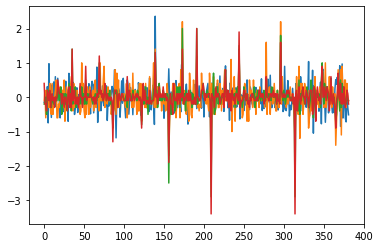

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


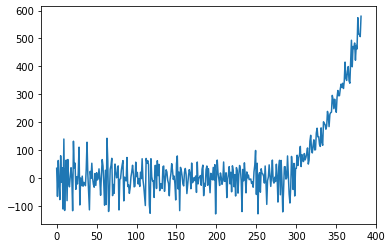

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


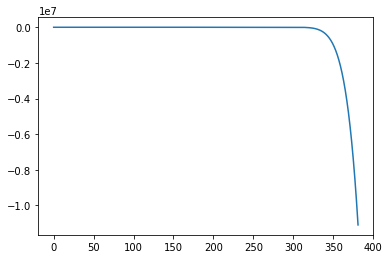

error is 933228134871873.0
data used was:		 order= (14, 7, 7) 		 seasonal_order=  (1, 2, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)']]
Test run so far 1


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


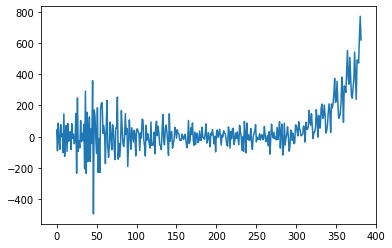

error is 8015453.133806421
data used was:		 order= (2, 3, 3) 		 seasonal_order=  (1, 3, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)']]
Test run so far 2


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


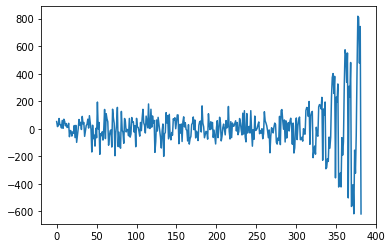

error is 9705680.412307294
data used was:		 order= (14, 0, 7) 		 seasonal_order=  (0, 3, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)']]
Test run so far 3


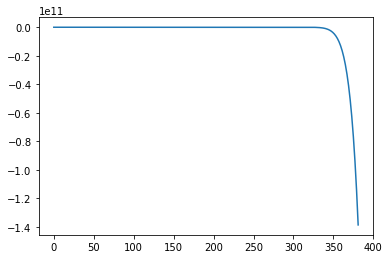

error is 1.0560810037936398e+23
data used was:		 order= (4, 9, 10) 		 seasonal_order=  (3, 3, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)']]
Test run so far 4


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


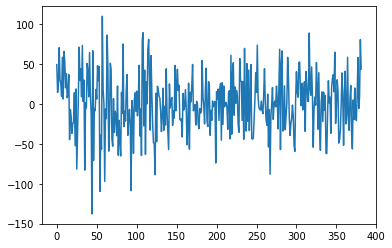

error is 523879.2267511266
data used was:		 order= (19, 0, 9) 		 seasonal_order=  (3, 2, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)']]
Test run so far 5


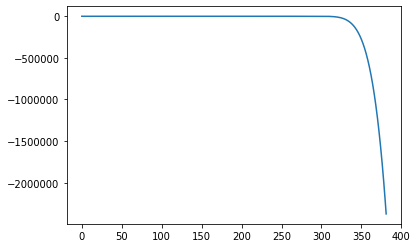

error is 47894338734701.336
data used was:		 order= (3, 7, 8) 		 seasonal_order=  (2, 0, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)']]
Test run so far 6


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


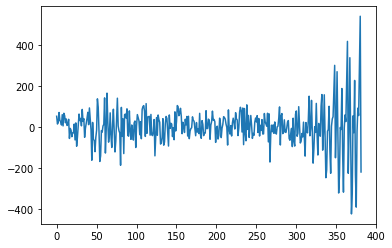

error is 3369955.734948864
data used was:		 order= (20, 0, 3) 		 seasonal_order=  (1, 3, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)']]
Test run so far 7


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


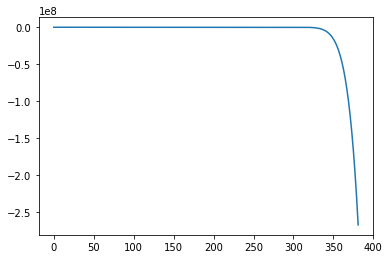

error is 4.7490294421192045e+17
data used was:		 order= (6, 8, 7) 		 seasonal_order=  (1, 1, 1, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)']]
Test run so far 8


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


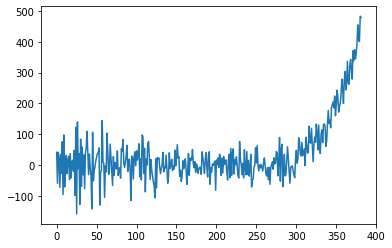

error is 4408633.946910725
data used was:		 order= (16, 2, 6) 		 seasonal_order=  (2, 2, 1, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


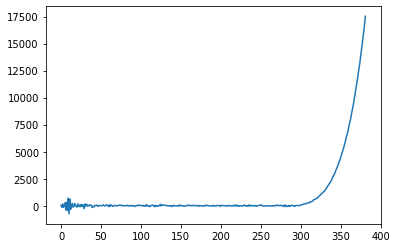

error is 3750303462.026885
data used was:		 order= (17, 6, 3) 		 seasonal_order=  (3, 1, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


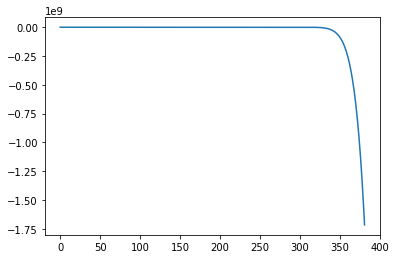

error is 1.8543319488348336e+19
data used was:		 order= (20, 7, 1) 		 seasonal_order=  (0, 3, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


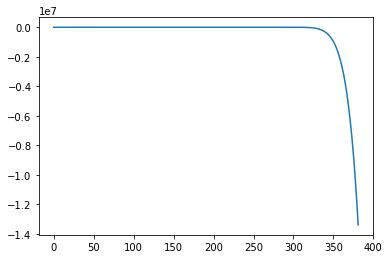

error is 1262158679851477.2
data used was:		 order= (13, 8, 10) 		 seasonal_order=  (2, 2, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


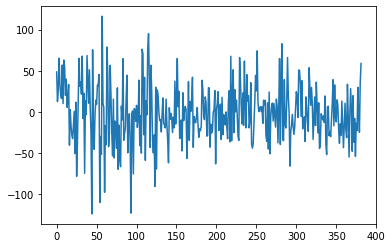

error is 467850.53222069377
data used was:		 order= (13, 0, 1) 		 seasonal_order=  (0, 2, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

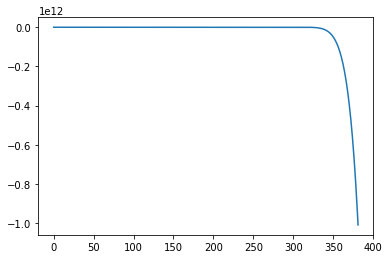

error is 6.46663378447885e+24
data used was:		 order= (7, 9, 3) 		 seasonal_order=  (2, 2, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


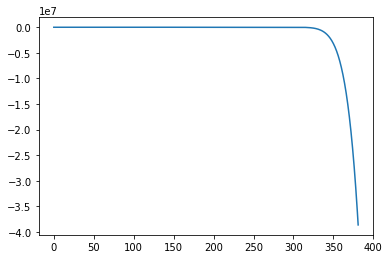

error is 1.1018497610386132e+16
data used was:		 order= (5, 6, 8) 		 seasonal_order=  (0, 3, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


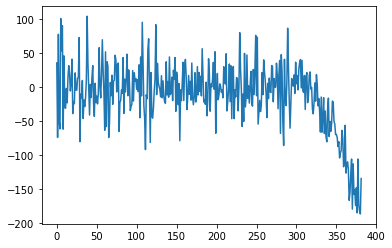

error is 967858.3655923689
data used was:		 order= (12, 4, 8) 		 seasonal_order=  (3, 0, 1, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


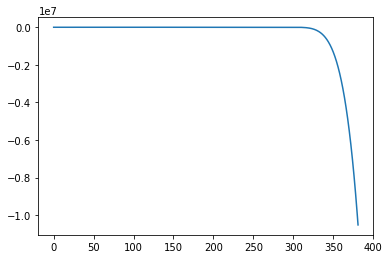

error is 970447189942985.5
data used was:		 order= (18, 6, 1) 		 seasonal_order=  (3, 2, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


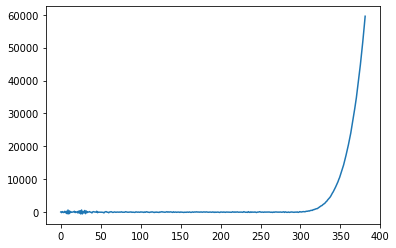

error is 36867061816.50013
data used was:		 order= (10, 5, 10) 		 seasonal_order=  (1, 2, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


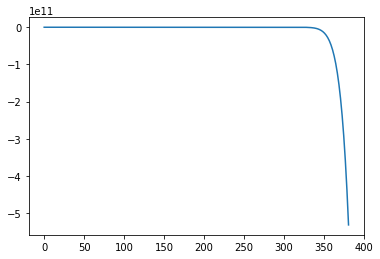

error is 1.537711411096891e+24
data used was:		 order= (10, 10, 0) 		 seasonal_order=  (1, 0, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


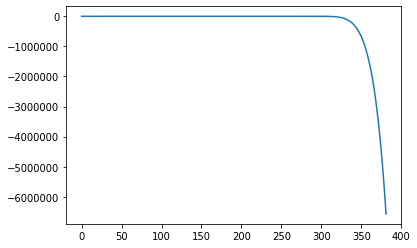

error is 344423728957832.5
data used was:		 order= (12, 6, 10) 		 seasonal_order=  (3, 3, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


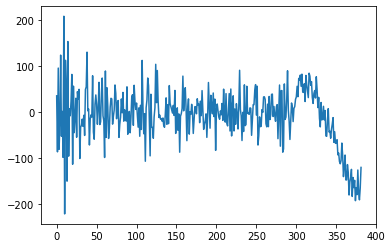

error is 1383376.928452536
data used was:		 order= (11, 4, 1) 		 seasonal_order=  (0, 1, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


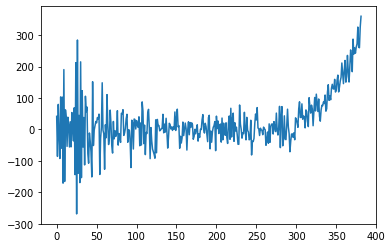

error is 2937065.3113437966
data used was:		 order= (13, 3, 5) 		 seasonal_order=  (3, 2, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


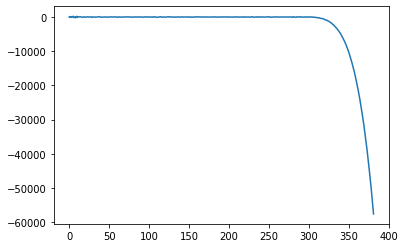

error is 34005553579.859932
data used was:		 order= (19, 6, 10) 		 seasonal_order=  (2, 0, 1, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


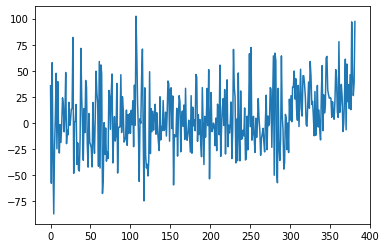

error is 366338.60240439686
data used was:		 order= (2, 3, 7) 		 seasonal_order=  (3, 0, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


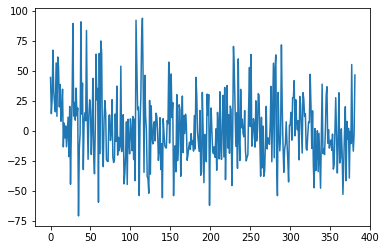

error is 320131.1643769659
data used was:		 order= (12, 0, 8) 		 seasonal_order=  (1, 1, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


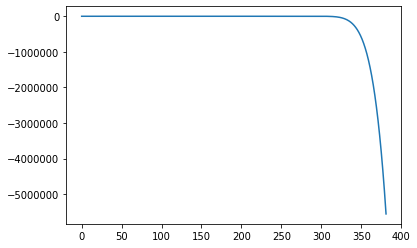

error is 250287672931685.94
data used was:		 order= (7, 6, 10) 		 seasonal_order=  (1, 2, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

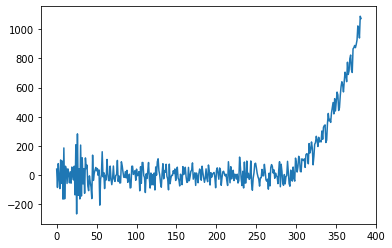

error is 23541526.049511567
data used was:		 order= (6, 3, 1) 		 seasonal_order=  (1, 2, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


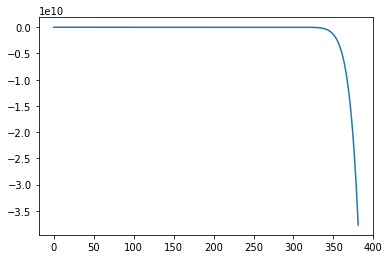

error is 8.256355335618512e+21
data used was:		 order= (4, 9, 5) 		 seasonal_order=  (0, 2, 1, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


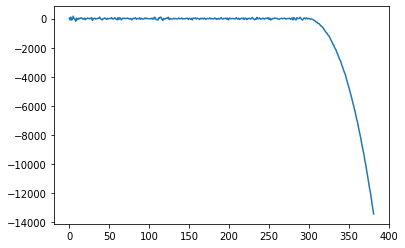

error is 2822001909.9047637
data used was:		 order= (7, 5, 2) 		 seasonal_order=  (0, 0, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


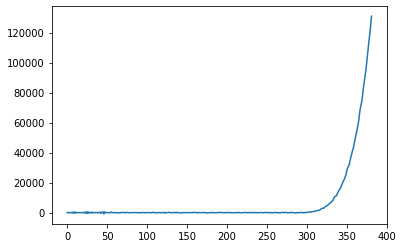

error is 188962272710.73315
data used was:		 order= (8, 4, 9) 		 seasonal_order=  (0, 3, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


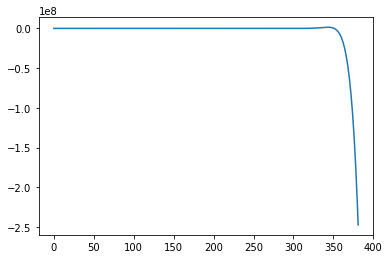

error is 2.8417073079886022e+17
data used was:		 order= (16, 10, 7) 		 seasonal_order=  (1, 1, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


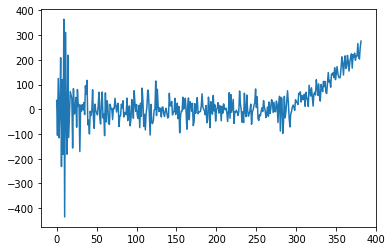

error is 2799470.1959727984
data used was:		 order= (8, 5, 5) 		 seasonal_order=  (3, 1, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


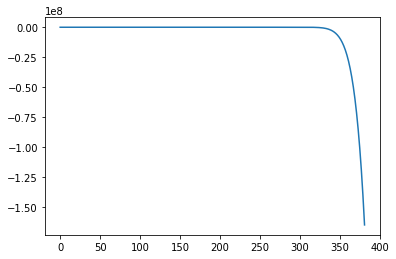

error is 1.7484048789681654e+17
data used was:		 order= (17, 8, 2) 		 seasonal_order=  (3, 2, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


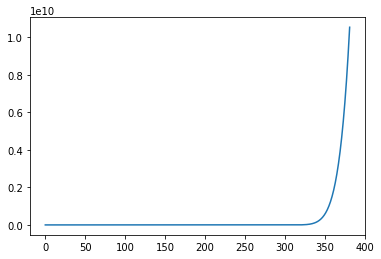

error is 7.296971548075643e+20
data used was:		 order= (11, 8, 1) 		 seasonal_order=  (0, 3, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


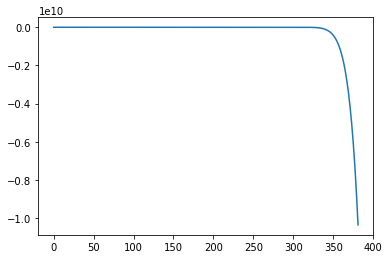

error is 6.398114672827096e+20
data used was:		 order= (18, 9, 3) 		 seasonal_order=  (0, 3, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


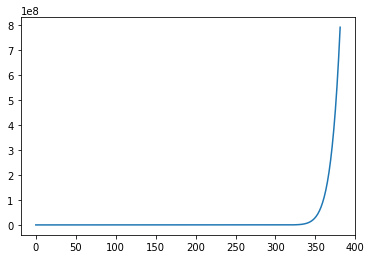

error is 3.697031542946377e+18
data used was:		 order= (16, 9, 2) 		 seasonal_order=  (2, 1, 1, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


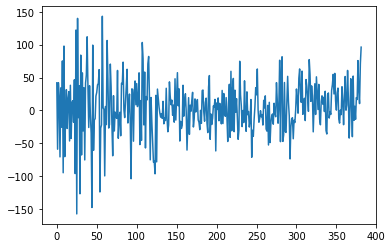

error is 666996.1239044588
data used was:		 order= (17, 2, 4) 		 seasonal_order=  (2, 2, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


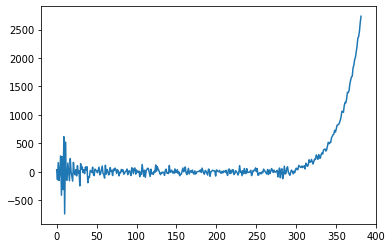

error is 95019426.87872005
data used was:		 order= (15, 6, 5) 		 seasonal_order=  (2, 1, 1, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


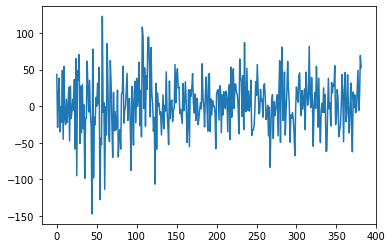

error is 534998.0973265711
data used was:		 order= (19, 1, 3) 		 seasonal_order=  (3, 2, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


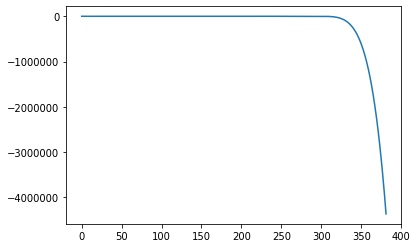

error is 175603791673858.53
data used was:		 order= (15, 6, 1) 		 seasonal_order=  (1, 1, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


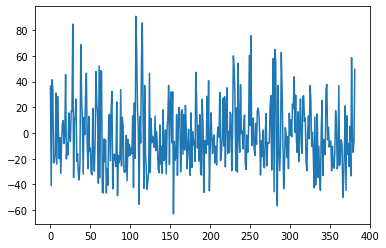

error is 279759.94252428086
data used was:		 order= (12, 2, 6) 		 seasonal_order=  (0, 0, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

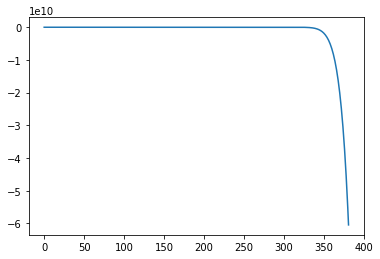

error is 2.0274372612158195e+22
data used was:		 order= (3, 10, 7) 		 seasonal_order=  (2, 1, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


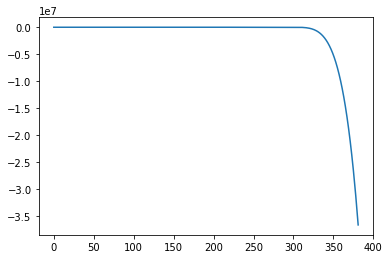

error is 1.2337269712182098e+16
data used was:		 order= (6, 7, 4) 		 seasonal_order=  (0, 0, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


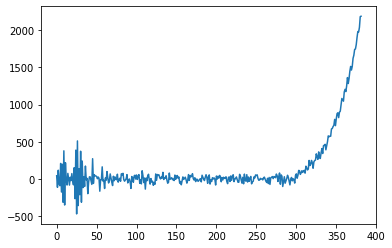

error is 78511899.31638193
data used was:		 order= (17, 4, 6) 		 seasonal_order=  (2, 2, 1, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


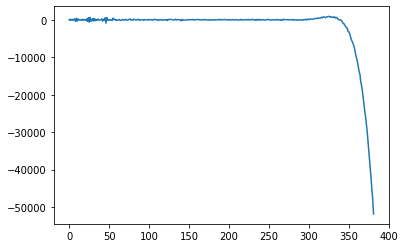

error is 20130877074.152306
data used was:		 order= (14, 4, 2) 		 seasonal_order=  (0, 3, 1, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


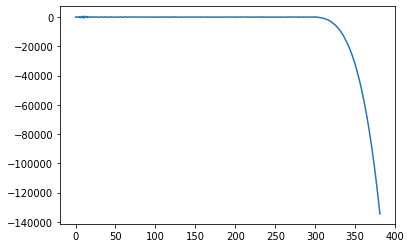

error is 217770411487.61322
data used was:		 order= (6, 6, 4) 		 seasonal_order=  (0, 1, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


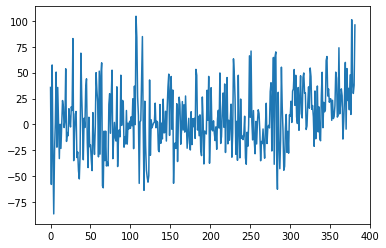

error is 367512.6808117263
data used was:		 order= (1, 3, 4) 		 seasonal_order=  (2, 0, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t se

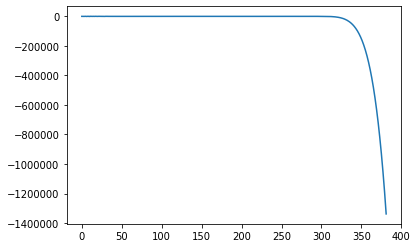

error is 14942997836638.568
data used was:		 order= (9, 7, 4) 		 seasonal_order=  (3, 1, 1, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


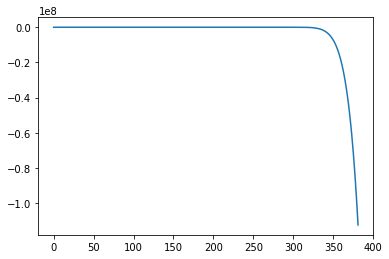

error is 8.617979465019147e+16
data used was:		 order= (7, 7, 8) 		 seasonal_order=  (1, 3, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


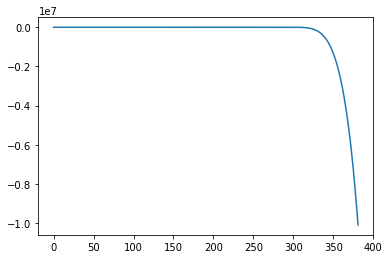

error is 911627725536559.4
data used was:		 order= (15, 6, 0) 		 seasonal_order=  (2, 1, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

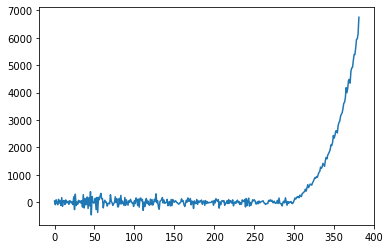

error is 656648451.2000881
data used was:		 order= (5, 3, 1) 		 seasonal_order=  (1, 3, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t se

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


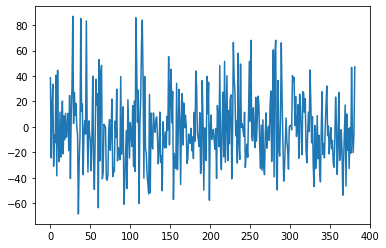

error is 310651.9519846557
data used was:		 order= (5, 1, 8) 		 seasonal_order=  (1, 1, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t se

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


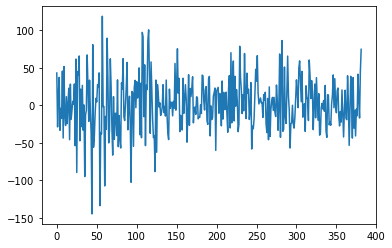

error is 494199.3673338338
data used was:		 order= (8, 1, 2) 		 seasonal_order=  (0, 2, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t se

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


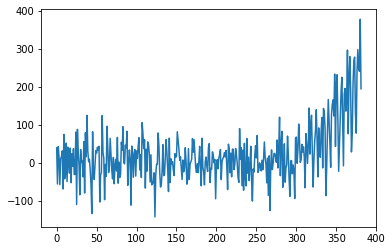

error is 2312643.44251709
data used was:		 order= (14, 2, 1) 		 seasonal_order=  (2, 2, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t se

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


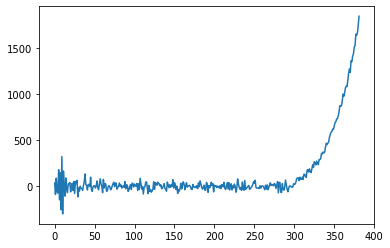

error is 52287378.573062725
data used was:		 order= (18, 4, 10) 		 seasonal_order=  (1, 1, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


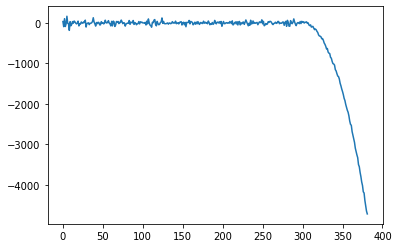

error is 359078198.02745384
data used was:		 order= (11, 5, 3) 		 seasonal_order=  (1, 0, 1, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


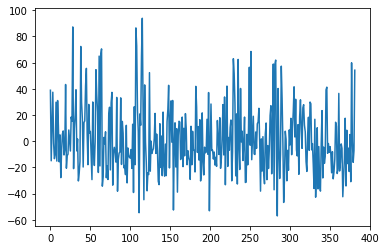

error is 265774.3396986433
data used was:		 order= (12, 0, 9) 		 seasonal_order=  (0, 0, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


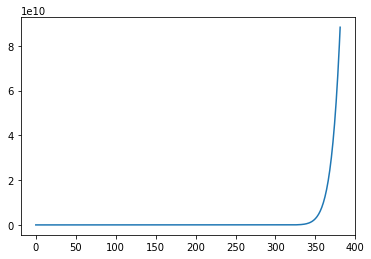

error is 4.4131493500720584e+22
data used was:		 order= (1, 9, 4) 		 seasonal_order=  (0, 2, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


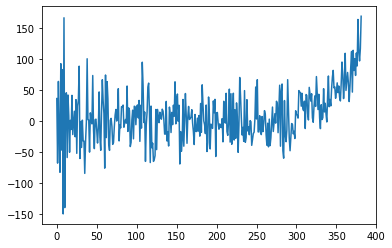

error is 723528.8591476852
data used was:		 order= (13, 3, 6) 		 seasonal_order=  (0, 1, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


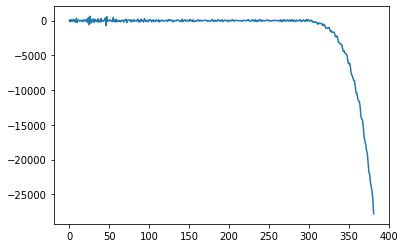

error is 8567341127.809602
data used was:		 order= (7, 4, 4) 		 seasonal_order=  (3, 3, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t se

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


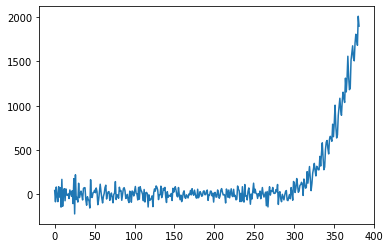

error is 63804369.730026424
data used was:		 order= (13, 3, 2) 		 seasonal_order=  (1, 2, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

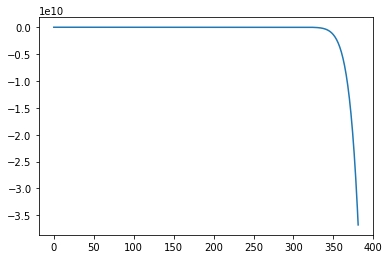

error is 7.987557299890623e+21
data used was:		 order= (16, 8, 10) 		 seasonal_order=  (1, 3, 1, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


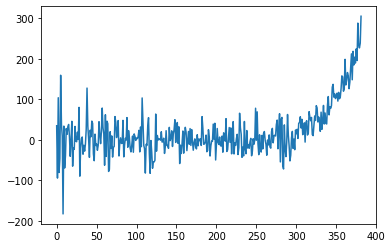

error is 1619860.9634381346
data used was:		 order= (4, 5, 9) 		 seasonal_order=  (2, 0, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


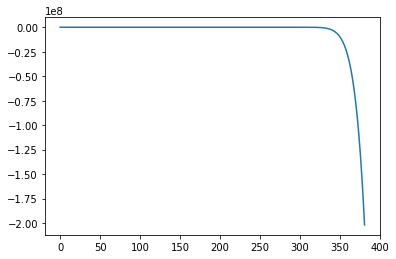

error is 2.5372754587504166e+17
data used was:		 order= (17, 8, 4) 		 seasonal_order=  (2, 2, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


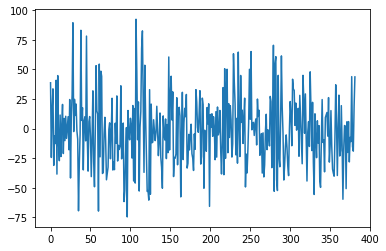

error is 333496.8962271787
data used was:		 order= (11, 1, 5) 		 seasonal_order=  (3, 1, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


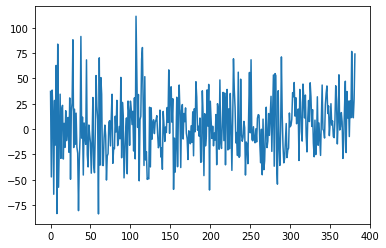

error is 359295.16649010347
data used was:		 order= (14, 2, 9) 		 seasonal_order=  (1, 1, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


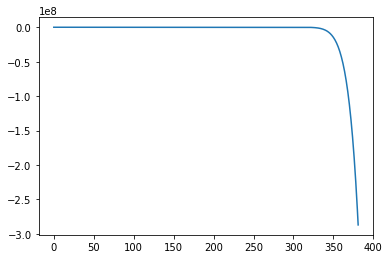

error is 5.229276876524071e+17
data used was:		 order= (17, 7, 5) 		 seasonal_order=  (3, 3, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


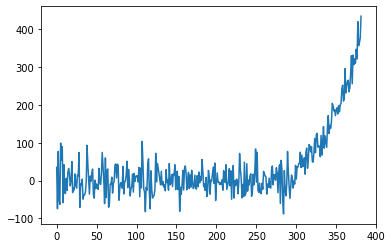

error is 3483821.9543914306
data used was:		 order= (14, 4, 7) 		 seasonal_order=  (3, 0, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


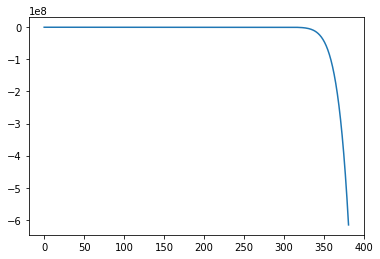

error is 2.6505286752574474e+18
data used was:		 order= (7, 8, 7) 		 seasonal_order=  (0, 1, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


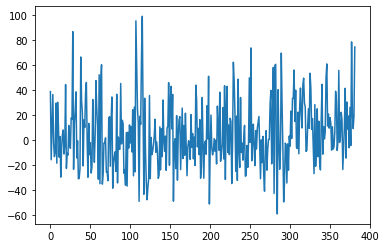

error is 286228.0783783869
data used was:		 order= (18, 0, 5) 		 seasonal_order=  (2, 0, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

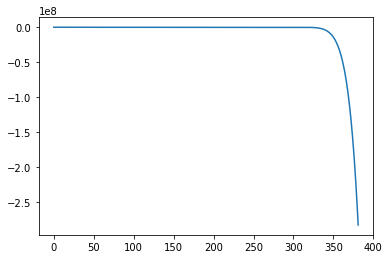

error is 5.071855450478079e+17
data used was:		 order= (18, 7, 9) 		 seasonal_order=  (1, 3, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


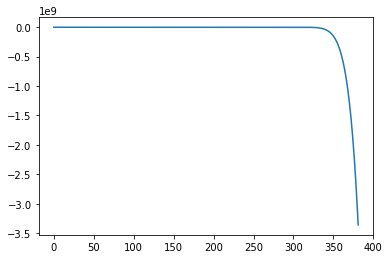

error is 6.9897695332720755e+19
data used was:		 order= (7, 9, 10) 		 seasonal_order=  (3, 1, 1, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


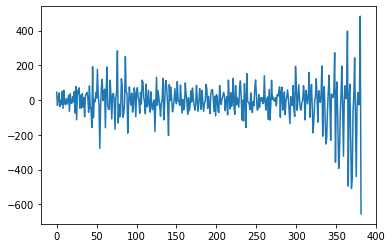

error is 4523470.514470588
data used was:		 order= (3, 1, 2) 		 seasonal_order=  (3, 3, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t se

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


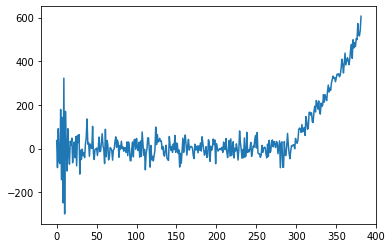

error is 8834481.912998352
data used was:		 order= (20, 4, 5) 		 seasonal_order=  (1, 1, 1, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


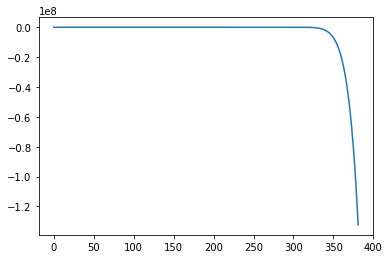

error is 1.1195893270705067e+17
data used was:		 order= (19, 7, 7) 		 seasonal_order=  (2, 3, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


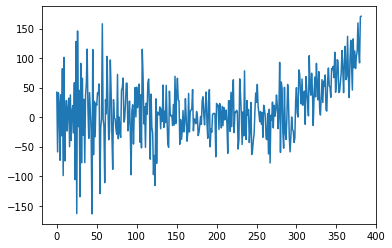

error is 1126082.0583274246
data used was:		 order= (16, 2, 7) 		 seasonal_order=  (1, 2, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


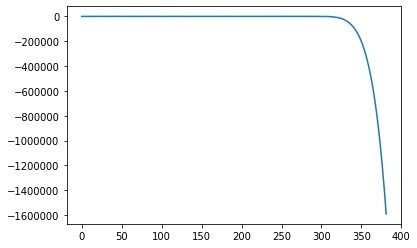

error is 22032293621599.81
data used was:		 order= (10, 5, 10) 		 seasonal_order=  (1, 3, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


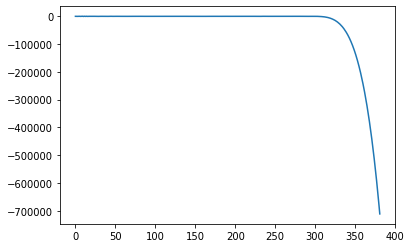

error is 5277836354965.0205
data used was:		 order= (12, 5, 0) 		 seasonal_order=  (1, 1, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


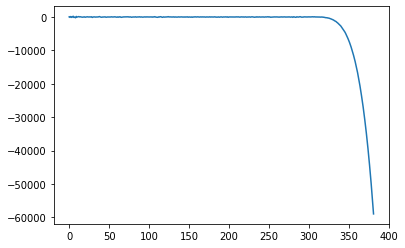

error is 30149010766.25321
data used was:		 order= (9, 6, 8) 		 seasonal_order=  (2, 0, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t se

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


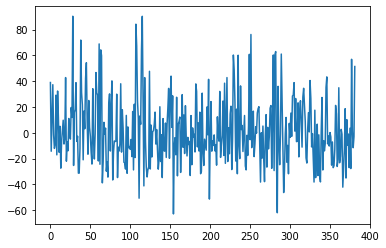

error is 264481.65429872624
data used was:		 order= (8, 0, 10) 		 seasonal_order=  (1, 0, 1, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


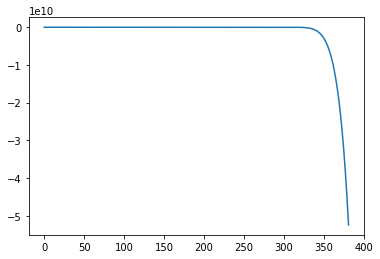

error is 1.8131253285711927e+22
data used was:		 order= (2, 8, 1) 		 seasonal_order=  (3, 2, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


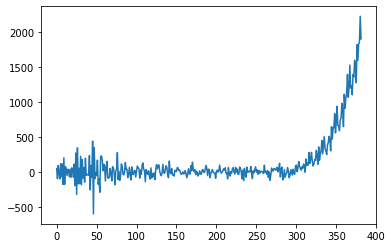

error is 60501372.34111162
data used was:		 order= (19, 3, 4) 		 seasonal_order=  (1, 3, 1, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

error occured on this run


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


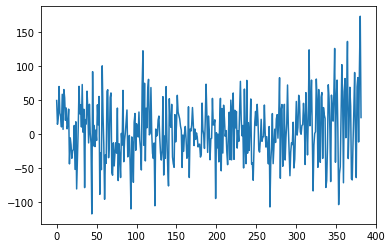

error is 772841.2618949162
data used was:		 order= (18, 0, 9) 		 seasonal_order=  (2, 2, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

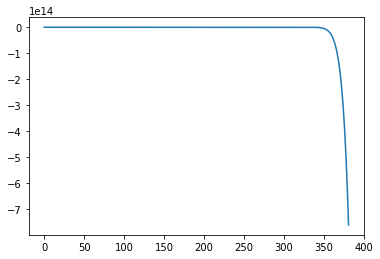

error is 2.4182810257538727e+30
data used was:		 order= (11, 9, 3) 		 seasonal_order=  (0, 3, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


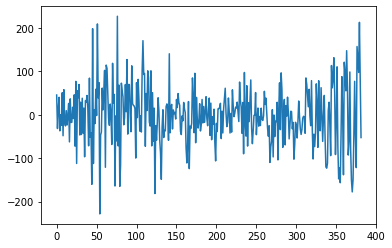

error is 1693670.4739695475
data used was:		 order= (3, 1, 5) 		 seasonal_order=  (1, 3, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


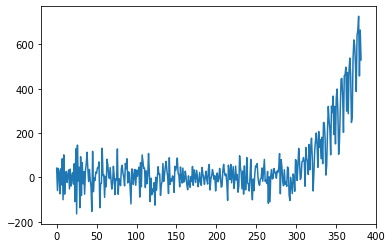

error is 8925822.752738183
data used was:		 order= (12, 2, 8) 		 seasonal_order=  (1, 2, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


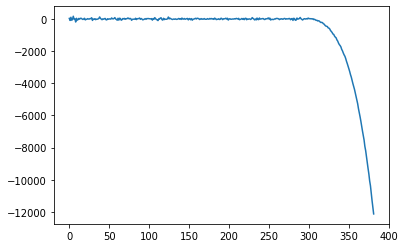

error is 1833874353.5224206
data used was:		 order= (19, 5, 10) 		 seasonal_order=  (0, 0, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


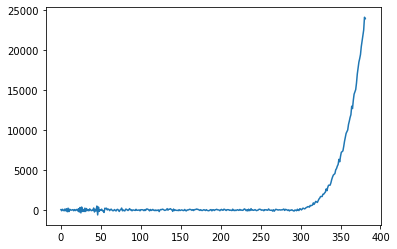

error is 7741342684.701165
data used was:		 order= (17, 3, 7) 		 seasonal_order=  (0, 3, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


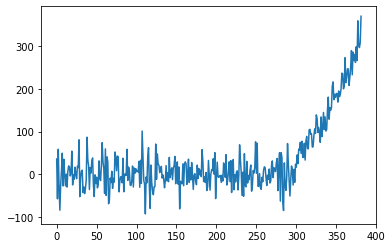

error is 2975052.3394181724
data used was:		 order= (10, 3, 1) 		 seasonal_order=  (3, 0, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


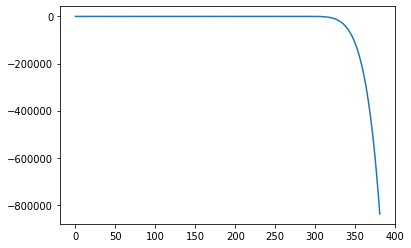

error is 6245268019398.026
data used was:		 order= (11, 7, 8) 		 seasonal_order=  (1, 1, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


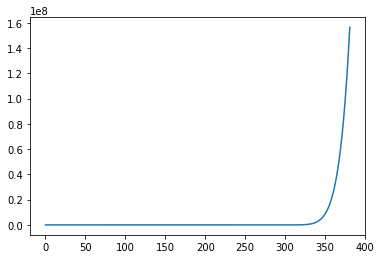

error is 1.607715095648957e+17
data used was:		 order= (14, 8, 5) 		 seasonal_order=  (0, 0, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t

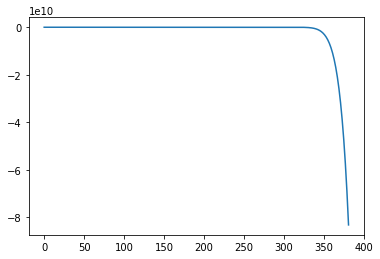

error is 3.940439420878199e+22
data used was:		 order= (11, 9, 1) 		 seasonal_order=  (1, 3, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


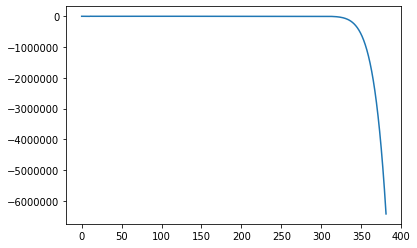

error is 317271280421017.2
data used was:		 order= (15, 8, 8) 		 seasonal_order=  (1, 1, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


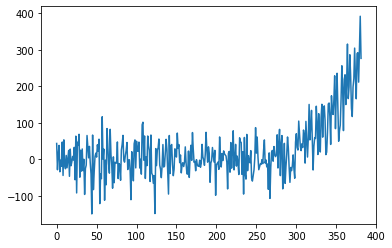

error is 2590397.734529392
data used was:		 order= (8, 1, 4) 		 seasonal_order=  (3, 2, 0, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t se

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


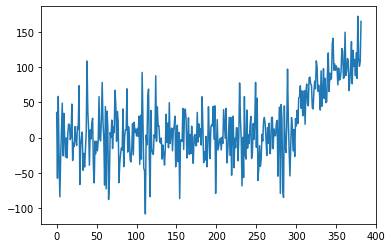

error is 1014916.8385029535
data used was:		 order= (13, 3, 0) 		 seasonal_order=  (0, 0, 2, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


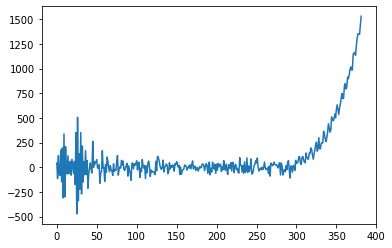

error is 37696631.371293396
data used was:		 order= (12, 4, 4) 		 seasonal_order=  (1, 2, 1, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


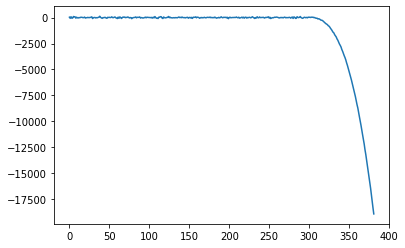

error is 4696984775.848753
data used was:		 order= (14, 4, 0) 		 seasonal_order=  (3, 0, 3, 16)
[['error is933228134871873.0', 'data used was:\t\torder=(14, 7, 7)\t\t seasonal_order= (1, 2, 2, 16)'], ['error is8015453.133806421', 'data used was:\t\torder=(2, 3, 3)\t\t seasonal_order= (1, 3, 2, 16)'], ['error is9705680.412307294', 'data used was:\t\torder=(14, 0, 7)\t\t seasonal_order= (0, 3, 0, 16)'], ['error is1.0560810037936398e+23', 'data used was:\t\torder=(4, 9, 10)\t\t seasonal_order= (3, 3, 0, 16)'], ['error is523879.2267511266', 'data used was:\t\torder=(19, 0, 9)\t\t seasonal_order= (3, 2, 2, 16)'], ['error is47894338734701.336', 'data used was:\t\torder=(3, 7, 8)\t\t seasonal_order= (2, 0, 2, 16)'], ['error is3369955.734948864', 'data used was:\t\torder=(20, 0, 3)\t\t seasonal_order= (1, 3, 0, 16)'], ['error is4.7490294421192045e+17', 'data used was:\t\torder=(6, 8, 7)\t\t seasonal_order= (1, 1, 1, 16)'], ['error is4408633.946910725', 'data used was:\t\torder=(16, 2, 6)\t\t s

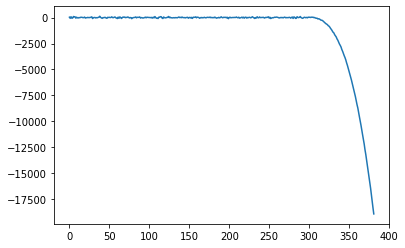

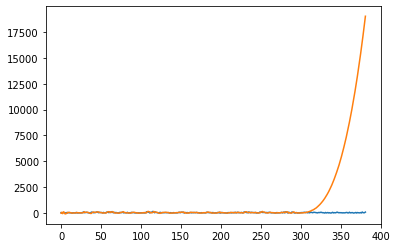

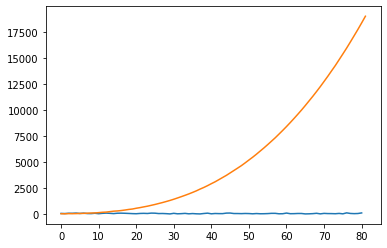

In [81]:
a=[reader.TRMM_acc_list[j][0][0] for j in range(0, 1146)]
a=separateByMonth(reader.sortedKeys_acc_TRMM,a,[9,10,11,12])
a_input=a[0:300]


# a=np.sqrt(a)
# a=a.flatten()
# x=flatten(rolmean(a, 16))
# a=a[15:]
# a=[a[j]-x[j] for j in range(len(a))]
# a=differencing(1, a) #DIFFERENCED TRMM
# a=[j/4 for j in a]    #length is 366






b=reader.DMI_list
b=separateByMonth(reader.sortedKeys_DMI, b, [9, 10, 11, 12])
b=differencing(1, b) #ALREADY STATIONARIZED DMI

c=reader.ElNino_list[0]
c=separateByMonth(reader.sortedKeys_Nino[0], c, [ 9, 10, 11, 12])
c=differencing(1, c)  #STATIONARIZED ELNINO12




d=reader.ElNino_list[1]
d=separateByMonth(reader.sortedKeys_Nino[1], d, [ 9, 10, 11, 12])
d=differencing(1, d) #STATIONARIZED ELNINO3

e=reader.ElNino_list[2]
e=separateByMonth(reader.sortedKeys_Nino[2], e, [ 9, 10, 11, 12])
e=differencing(1, e) #STATIONARIZED ELNINO3.4






f=reader.ElNino_list[3]
f=separateByMonth(reader.sortedKeys_Nino[3], f, [8, 9, 10, 11, 12])
f=differencing(1, f) #STATIONARISED

b_input_exog = [[b[i],c[i],d[i],e[i]] for i in range(0,len(b))]
plt.plot(b_input_exog)
plt.show() #plot of exog varaibles


mod=SARIMAX(a_input, order=(3,3,1), seasonal_order=(1,1,0,17),exog=b_input_exog[0:300])
results=mod.fit()
forecastPrev=results.predict(start=0, end=381,exog=b_input_exog[300:len(b)] )#, exog=exog_test, dynamic=350)
forecast = results.forecast(steps=82,exog=b_input_exog[300:len(b)])
error=a-forecastPrev
plt.plot(error)
plt.show()
# exog=b[480-382:]
# exog_train=exog
# exog_test=[exog[350:381]
# train=a[:329]

data = []
"""
for i in range(100):
    
    
    #mod=SARIMAX(a_input, order=(random.randint(1,20),1,1), seasonal_order=(1,1,0,16),exog=b[0:300])
    try:
        mod=generateRandomInput(a_input,b_input_exog)

        results=mod.fit()
        forecastPrev=results.predict(start=0, end=381,exog=b_input_exog[300:len(b)] )#, exog=exog_test, dynamic=350)
        forecast = results.forecast(steps=82,exog=b_input_exog[300:len(b)])
        error=a-forecastPrev
        plt.plot(error)
        plt.show()
        data.append(["error is"+str(sum([i*i for i in error])),"data used was:\t\t"+ "order="+str(mod.order)+ "\t\t seasonal_order= "+str(mod.seasonal_order) ] )
        print("error is",sum([i*i for i in error]))
        print("data used was:\t\t", "order=",mod.order, "\t\t seasonal_order= ",mod.seasonal_order)


        print(data)
        print("Test run so far",i+1)
    except:
        print("error occured on this run")
"""
#results.forecast(steps=test_size-1, exog=test_X)

print(len(forecast))
# plt.plot(a, label='Observed')
# plt.plot(forecast, label="Forecast")

# plt.axvline(300, color='g', linewidth=0.25)
# plt.legend()
# plt.show()
error=a-forecastPrev
plt.plot(error)
plt.show()
plt.plot(a)
plt.plot(forecastPrev)
plt.show()
plt.plot(a[301:])
plt.plot(forecast)
plt.show()

